<a href="https://colab.research.google.com/github/sira4154/AI4BA/blob/main/Select_model_for_forecasting_revise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select model for forecasting

ไฟล์เอกสารนี้จัดทำขึ้นเพื่อเปรียบเทียบ ประสิทธิภาพ ความแม่นยำของแต่ละโมเดล เพื่อเป็นส่วนหนึ่งในการตัดสินใจ นำไปใช้ในแอพพลิเคชั่น การทำนายหุ้น โดยโมเดลที่เราจะนำมาใช้ในการตัดสินใจมีทั้งหมด 5 โมเดล ได้แก่


1.   Prophet model 
2.   LSTM model
3.   Simple RNN model
4.   Convolutional 1D model
5.   Auto arima 

โดยที่ทั้ง 5 โมเดลจะนำไปทำนายราคาหุ้นจำนวน 5 หุ้น ที่อยู่ในตลาดของ SET100 และเราจะนำผลลัพธ์การทำนาย ไปวัดประสิทธิภาพ โดยตัดสินใจจาก MSE(mean square error), MAE(mean absolute error), RMSE(root mean square error)


# Install Package and import library

In [ ]:
!pip install yfinance

In [ ]:
!pip install bs4

In [ ]:
!pip install pmdarima

In [ ]:
from datetime import date
import yfinance as yf
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from plotly import graph_objs as go
from bs4 import BeautifulSoup 
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout,Bidirectional, SimpleRNN, Conv1D, MaxPool1D, GlobalMaxPooling1D
from tensorflow.keras.utils import set_random_seed
from sklearn.preprocessing import StandardScaler

from pmdarima import auto_arima

เช็คสถานะ GPU

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


เก็บรายชื่อหุ้นทั้งหมด 100 หุ้นใน SET100

In [ ]:
def thai_stock():
    url = "https://www.settrade.com/C13_MarketSummary.jsp?detail=SET100"
    data = requests.get(url).text
    soup = BeautifulSoup(data, "html.parser")
    selector = 'a.link-stt'
    symbols = soup.select(selector)
    set100 = list(map(lambda s: s.text, symbols[9:109]))
    set100BK = [i +".BK" for i in set100]
    return set100BK

In [ ]:
thai_sc = thai_stock()

In [ ]:
print(thai_sc)

['ACE.BK', 'ADVANC.BK', 'AEONTS.BK', 'AMATA.BK', 'AOT.BK', 'AP.BK', 'AWC.BK', 'BAM.BK', 'BANPU.BK', 'BBL.BK', 'BCH.BK', 'BCP.BK', 'BCPG.BK', 'BDMS.BK', 'BEC.BK', 'BEM.BK', 'BGRIM.BK', 'BH.BK', 'BLA.BK', 'BPP.BK', 'BTS.BK', 'CBG.BK', 'CENTEL.BK', 'CHG.BK', 'CK.BK', 'CKP.BK', 'COM7.BK', 'CPALL.BK', 'CPF.BK', 'CPN.BK', 'CRC.BK', 'DOHOME.BK', 'DTAC.BK', 'EA.BK', 'EGCO.BK', 'EPG.BK', 'ESSO.BK', 'GLOBAL.BK', 'GPSC.BK', 'GULF.BK', 'GUNKUL.BK', 'HANA.BK', 'HMPRO.BK', 'INTUCH.BK', 'IRPC.BK', 'IVL.BK', 'JMART.BK', 'JMT.BK', 'KBANK.BK', 'KCE.BK', 'KEX.BK', 'KKP.BK', 'KTB.BK', 'KTC.BK', 'LH.BK', 'MAJOR.BK', 'MEGA.BK', 'MINT.BK', 'MTC.BK', 'OR.BK', 'ORI.BK', 'OSP.BK', 'PLANB.BK', 'PTG.BK', 'PTT.BK', 'PTTEP.BK', 'PTTGC.BK', 'QH.BK', 'RATCH.BK', 'RBF.BK', 'RCL.BK', 'RS.BK', 'SAWAD.BK', 'SCB.BK', 'SCC.BK', 'SCGP.BK', 'SINGER.BK', 'SIRI.BK', 'SPALI.BK', 'SPRC.BK', 'STA.BK', 'STARK.BK', 'STEC.BK', 'STGT.BK', 'SUPER.BK', 'SYNEX.BK', 'TASCO.BK', 'TCAP.BK', 'THANI.BK', 'TIDLOR.BK', 'TISCO.BK', 'TOP.BK', 'T

กำหนดพารามิเตอร์

In [ ]:
START = "2019-01-01"  #กำหนดวันที้ที่ต้องการเริ่มเก็บข้อมูลจนถึงปัจจุบัน
TODAY = date.today().strftime("%Y-%m-%d") 
test_size = 15 #จำนวนวันที่ต้องทดสอบ 
time_step = 100 #time_step คือการกำหนดตัวแปรชุดก่อนหน้าที่จะนำมาใช้เป็น X_test

# Load Data

In [ ]:
def load_data(selected_stock,START, TODAY):
  data = yf.download(selected_stock, START, TODAY)
  data.reset_index(inplace=True)
  return data

# Prepare data for Prophet

In [ ]:
def create_data_prophet(data, test_size):
  data1 = data[['Date', 'Close']]
  data1 = data1.rename(columns={"Date": "ds", "Close": "y"})
  train_set = data1[:len(data)-test_size].copy()
  test_set = data1[len(data)-test_size:].copy().reset_index(drop = True)
  return train_set,test_set

# Prepare data for LSTM, RNN, Conv1D model 

In [ ]:
def train_test_log(data, test_size):
  df_log = data.set_index("Date")[["Close"]].copy()
  df_log['LogClose'] = np.log(df_log["Close"])
  df_log['DiffLogClose'] = df_log["LogClose"].diff()
  train = df_log.iloc[:-test_size]
  test = df_log.iloc[-test_size:]
  return train, test ,df_log 

def standard_scale(train, test, df_log):
  sc = StandardScaler()
  train_scaled = sc.fit_transform(train[['DiffLogClose']])
  test_scaled = sc.transform(test[['DiffLogClose']])
  train_idx = df_log.index <= train.index[-1]
  test_idx = df_log.index > train.index[-1]
  df_log.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
  df_log.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
  return df_log,sc

def create_dataset(datalog, time_step):
  datalog = datalog['ScaledLogReturn'].dropna().to_numpy()
  dataX, dataY = [],[]
  for i in range(len(datalog)-time_step):
    dataX.append(datalog[i:(i+time_step)])                       
    dataY.append(datalog[i+time_step])  
  dataX = np.array(dataX)
  dataY = np.array(dataY)
  return dataX, dataY

def split_train_test_xy_log(X_log,y_log, test_size):
  X_train_log, y_train_log = X_log[:-test_size], y_log[:-test_size]
  X_test_log, y_test_log = X_log[-test_size:], y_log[-test_size:]
  X_train_log = X_train_log.reshape(X_train_log.shape[0], X_train_log.shape[1],1 ) 
  X_test_log = X_test_log.reshape(X_test_log.shape[0], X_test_log.shape[1], 1)
  return X_train_log, y_train_log,X_test_log, y_test_log

# Prophet model

In [ ]:
def prophet_model(train_set, test_set, data):
  m = Prophet()
  m.fit(train_set)
  forecast = m.predict(test_set)
  res_data = data[["Date","Close"]]
  res_y = forecast[["ds", "yhat"]]
  res_data = pd.merge(res_data, res_y, how='outer', left_on="Date",right_on="ds")
  res_data = res_data.set_index("Date")
  res_data = res_data.drop(columns = "ds",axis = 0)
  return res_data

# LSTM model 

In [ ]:
def LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step): 
  tf.keras.backend.clear_session()
  set_random_seed(42)
  model_LSTM = Sequential()
  model_LSTM.add(LSTM(128, return_sequences=True))
  model_LSTM.add(LSTM(64))
  model_LSTM.add(Dense(1))
  model_LSTM.compile(loss='mse', optimizer='adam')
  history = model_LSTM.fit(X_train_log, y_train_log, validation_data=(X_test_log, y_test_log), epochs=50, batch_size=128, verbose=0)
  return history,model_LSTM

# RNN model

In [ ]:
def RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step):
  tf.keras.backend.clear_session()
  set_random_seed(42)
  model_RNN = Sequential()
  model_RNN.add(SimpleRNN(128, return_sequences=True))
  model_RNN.add(SimpleRNN(64))
  model_RNN.add(Dense(1))
  model_RNN.compile(loss='mse', optimizer='adam')
  history = model_RNN.fit(X_train_log, y_train_log, validation_data=(X_test_log, y_test_log), epochs=50, batch_size=128, verbose=0)
  return history,model_RNN

# Conv1D model

In [ ]:
def CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step):
  tf.keras.backend.clear_session()
  set_random_seed(42)
  model_CNN = Sequential()
  model_CNN.add(SimpleRNN(128, return_sequences=True))
  model_CNN.add(SimpleRNN(64))
  model_CNN.add(Dense(1))
  model_CNN.compile(loss='mse', optimizer='adam')
  history = model_CNN.fit(X_train_log, y_train_log, validation_data=(X_test_log, y_test_log), epochs=50, batch_size=128, verbose=0)
  return history,model_CNN

# Auto arima model

In [ ]:
def auto_arima_model(train_set, test_set, data):
  training = train_set ['y']
  validation = test_set ['y']
  model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0,d=1, D=1, trace=False,error_action='ignore',suppress_warnings=True)
  model.fit(training)
  forecast = model.predict(n_periods=len(validation))
  arima_result = data.copy()
  arima_result["yhat"] = np.nan
  arima_result.loc[len(arima_result) - test_size:,"yhat"] = forecast
  return arima_result

# Prediction Deep Learning model 

In [ ]:
def predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model, sc, name_model):
    # multi-step forecast
    str_1step_train = name_model + "_1step_train"
    str_1step_test = name_model + "_1step_test"
    multistep_predictions = []
    last_x = X_test_log[0]
    while len(multistep_predictions) < len(X_test_log):
        p = model.predict(last_x.reshape(1, -1, 1))[0]
        multistep_predictions.append(p)
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
    multistep_predictions = np.array(multistep_predictions)
    multistep_predictions = sc.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()

  #predict
    train_predict_log = model.predict(X_train_log)
    test_predict_log =model.predict(X_test_log)
    train_predict_log = sc.inverse_transform(train_predict_log)
    test_predict_log = sc.inverse_transform(test_predict_log)

  #Create_result_dataframe
    df_result = df_log.copy()
    df_result['ShiftedLogClose'] = df_result['LogClose'].shift(1)
    prev = df_result['ShiftedLogClose']
    train_idx_log = df_result.iloc[time_step + 1:-test_size].index
    test_idx_log = df_result.iloc[-test_size:].index
    df_result.loc[train_idx_log, str_1step_train] = prev[train_idx_log] + train_predict_log.flatten()
    df_result.loc[test_idx_log, str_1step_test] = prev[test_idx_log] + test_predict_log.flatten()
    df_result.loc[test_idx_log, 'multistep'] = train.iloc[-1]['LogClose'] + np.cumsum(multistep_predictions)
    list_inv = [str_1step_train, str_1step_test, 'multistep']
    for i in list_inv :
      df_result[i + "_inv"] = np.exp(df_result[i])
    return df_result

# Calculate Score Prophet and Arima

In [ ]:
def cal_score(df_result, test_size, selected_stock,scores_model,name_model):
  df_eva = df_result.iloc[-test_size:, :]
  mae = mean_absolute_error(df_eva["Close"], df_eva["yhat"]) 
  mse = mean_squared_error(df_eva["Close"], df_eva["yhat"], squared = True)
  rmse = mean_squared_error(df_eva["Close"], df_eva["yhat"], squared = False)
  scores_model.append({'Model': name_model,'MAE': mae, 'MSE': mse,'RMSE': rmse, 
                   "Stock": selected_stock})
  return scores_model

# Calculate Score Deep learning (LSTM, RNN, CNN)

In [ ]:
def cal_score_dl(df_result, test_size, scores_model, selected_stock, name_model):
  df_result = df_result.dropna(axis = 0, subset = ["multistep_inv"])
  y_true = df_result["Close"].tolist()
  y_pred = df_result["multistep_inv"].tolist()
  mse = mean_squared_error(y_true, y_pred, squared = True)
  mae = mean_absolute_error(y_true, y_pred) 
  rmse = math.sqrt(mse)
  scores_model.append({'Model': name_model,'MAE': mae, 'MSE': mse ,'RMSE': rmse,
                    "Stock": selected_stock})
  return scores_model

เมื่อเราสร้างฟังก์ชั้่นหลักเสร็จเรียบร้อยแล้วจะนำฟังก์ชั่นเหล่านี้มาทำนาย หุ้นเป็นจำนวน 5 หุ้น

# หุ้นที่ 1 = AMATA

## Main Function 

In [ ]:
selected_stock = "AMATA.BK" 
def predict_stock_lstm(selected_stock, START, TODAY, time_step):
  data =  load_data(selected_stock,START, TODAY)
  train, test ,df_log = train_test_log(data,test_size)
  df_log,sc =  standard_scale(train, test, df_log)
  X_log, y_log = create_dataset(df_log, time_step)
  X_train_log, y_train_log,X_test_log, y_test_log = split_train_test_xy_log(X_log,y_log,test_size)

  #Prophet
  train_set,test_set = create_data_prophet(data, test_size)
  df_result_Prophet = prophet_model(train_set, test_set, data)

  #LSTM 
  history,model_LSTM = LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_LSTM = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_LSTM, sc, name_model = "LSTM")

  #RNN
  history,model_RNN = RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_RNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_RNN, sc, name_model = "RNN") 

  #Conv1D
  history,model_CNN = CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_CNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_CNN, sc, name_model = "CNN") 

  #Auto Arima 
  arima_result = auto_arima_model(train_set, test_set, data)
  
  return df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result

In [ ]:
df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result = predict_stock_lstm(selected_stock, START, TODAY, time_step)

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### แสดงกราฟผลลัพธ์แต่ละโมเดล

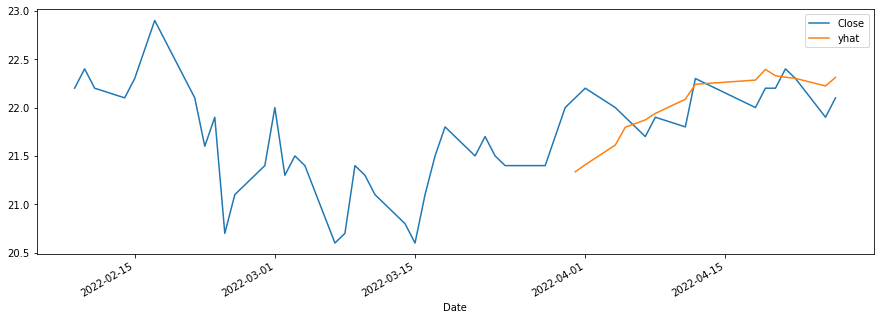

In [ ]:
df_result_Prophet[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

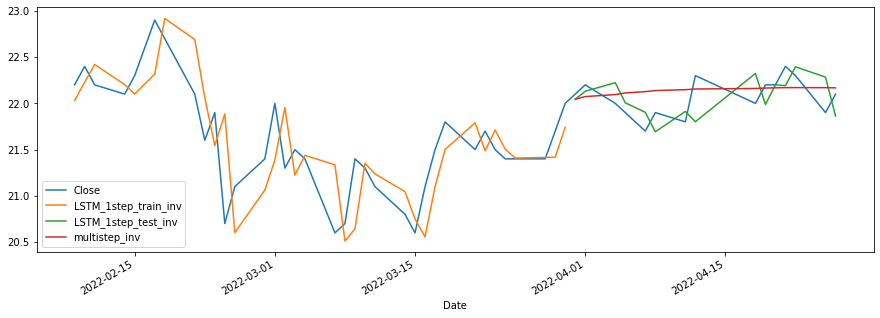

In [ ]:
df_result_LSTM[['Close', 'LSTM_1step_train_inv', 'LSTM_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

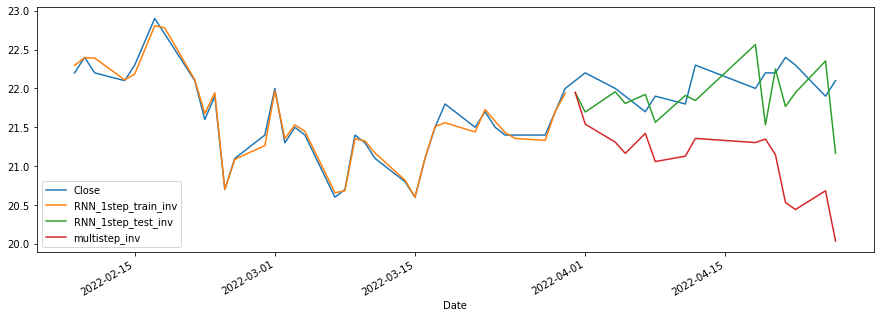

In [ ]:
df_result_RNN[['Close', 'RNN_1step_train_inv', 'RNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

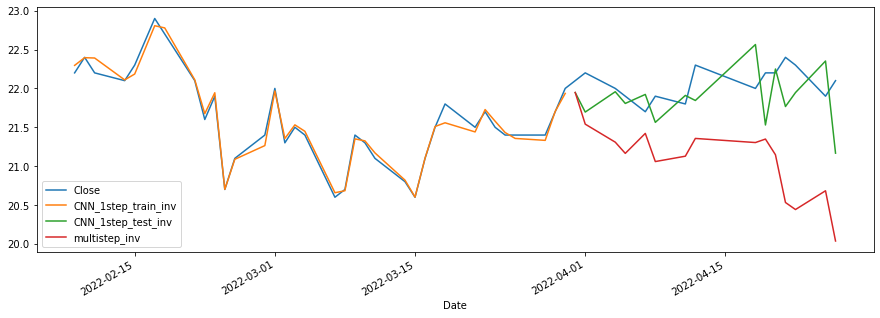

In [ ]:
df_result_CNN[['Close', 'CNN_1step_train_inv', 'CNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

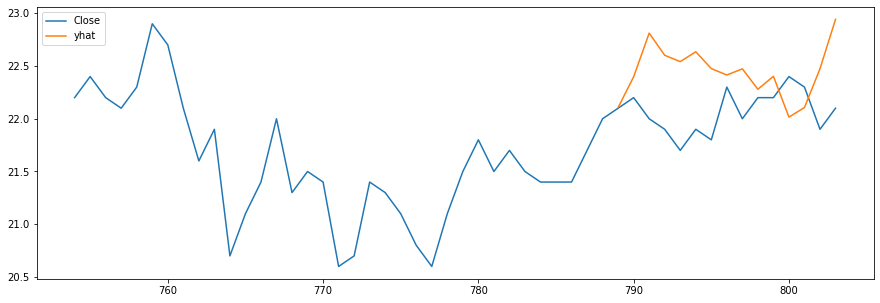

In [ ]:
arima_result[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

### Evaluate model 

In [ ]:
scores_model = []

# Prophet score 
scores_model_Prophet = cal_score(df_result_Prophet, test_size, selected_stock,scores_model,name_model = "Prophet")

# Auto Arima 
scores_model_Arima = cal_score(arima_result, test_size, selected_stock,scores_model,name_model = "Arima")

#LSTM 
scores_model_LSTM = cal_score_dl(df_result_LSTM, test_size ,scores_model, selected_stock, name_model = "LSTM")

#RNN
scores_model_RNN = cal_score_dl(df_result_RNN, test_size, scores_model, selected_stock, name_model = "RNN")

#CNN
scores_model_CNN = cal_score_dl(df_result_CNN, test_size, scores_model, selected_stock, name_model = "CNN")

# หุ้นที่ 2 = HANA

### Main Function 

In [ ]:
selected_stock = "HANA.BK" 
def predict_stock_lstm(selected_stock, START, TODAY, time_step):
  data =  load_data(selected_stock,START, TODAY)
  train, test ,df_log = train_test_log(data,test_size)
  df_log,sc =  standard_scale(train, test, df_log)
  X_log, y_log = create_dataset(df_log, time_step)
  X_train_log, y_train_log,X_test_log, y_test_log = split_train_test_xy_log(X_log,y_log,test_size)

  #Prophet
  train_set,test_set = create_data_prophet(data, test_size)
  df_result_Prophet = prophet_model(train_set, test_set, data)

  #LSTM 
  history,model_LSTM = LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_LSTM = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_LSTM, sc, name_model = "LSTM")

  #RNN
  history,model_RNN = RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_RNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_RNN,sc,  name_model = "RNN") 

  #Conv1D
  history,model_CNN = CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_CNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_CNN,sc, name_model = "CNN") 

  #Auto Arima 
  arima_result = auto_arima_model(train_set, test_set, data)
  
  return df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result

In [ ]:
df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result = predict_stock_lstm(selected_stock, START, TODAY, time_step)

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


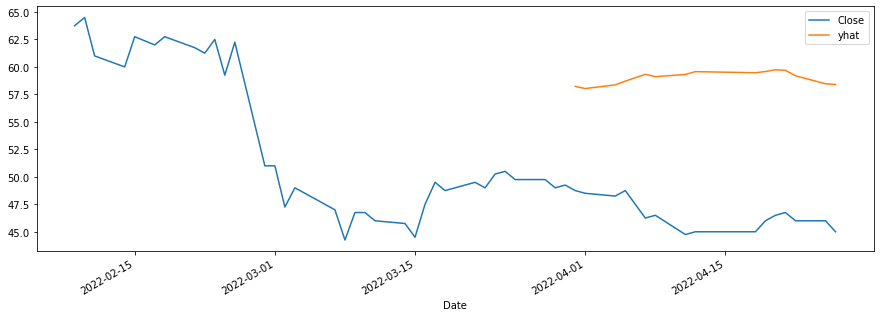

In [ ]:
df_result_Prophet[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

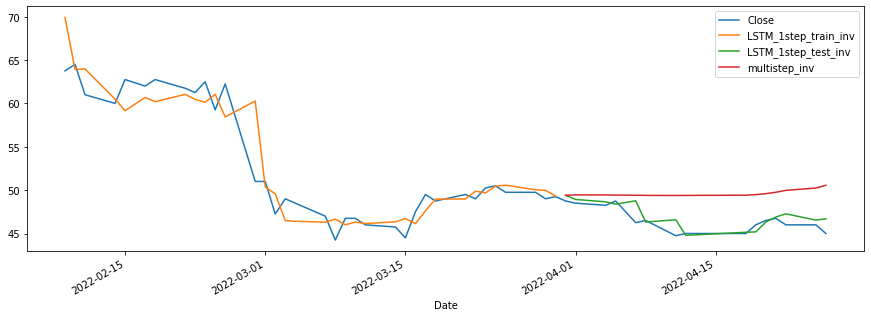

In [ ]:
df_result_LSTM[['Close', 'LSTM_1step_train_inv', 'LSTM_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

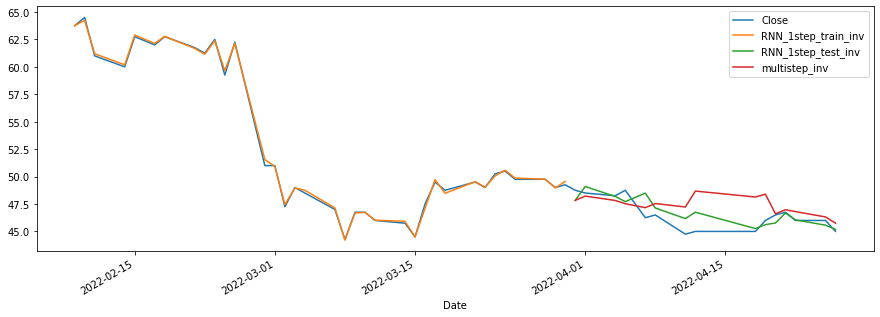

In [ ]:
df_result_RNN[['Close', 'RNN_1step_train_inv', 'RNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

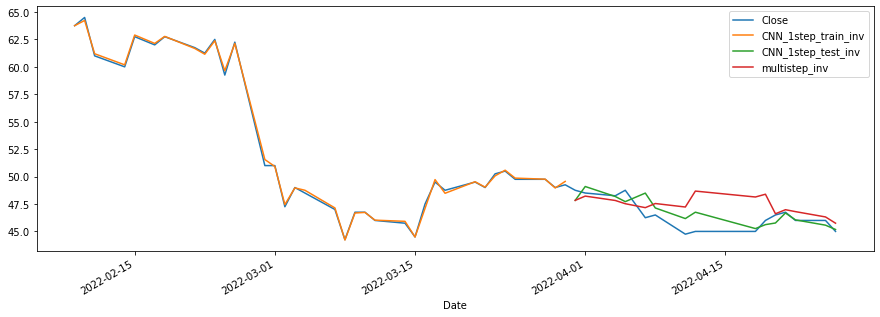

In [ ]:
df_result_CNN[['Close', 'CNN_1step_train_inv', 'CNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

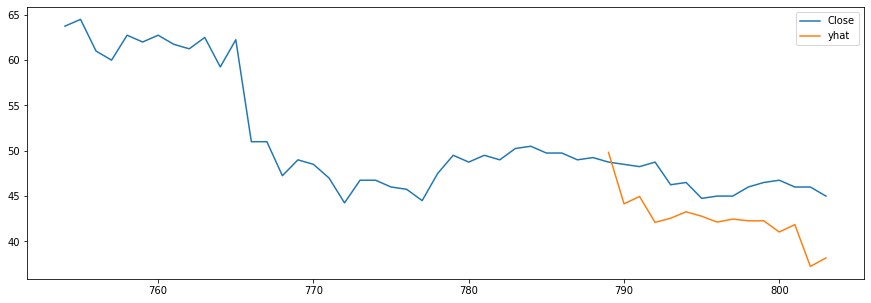

In [ ]:
arima_result[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

### Evaluate model

In [ ]:
# Prophet score 
scores_model_Prophet = cal_score(df_result_Prophet, test_size, selected_stock,scores_model,name_model = "Prophet")

# Auto Arima 
scores_model_Arima = cal_score(arima_result, test_size, selected_stock,scores_model,name_model = "Arima")

#LSTM 
scores_model_LSTM = cal_score_dl(df_result_LSTM, test_size ,scores_model, selected_stock, name_model = "LSTM")

#RNN
scores_model_RNN = cal_score_dl(df_result_RNN, test_size, scores_model, selected_stock, name_model = "RNN")

#CNN
scores_model_CNN = cal_score_dl(df_result_CNN, test_size, scores_model, selected_stock, name_model = "CNN")

# หุ้นที่ 3 = PLANB

### Main Function 

In [ ]:
selected_stock = "PLANB.BK" 
def predict_stock_lstm(selected_stock, START, TODAY, time_step):
  data =  load_data(selected_stock,START, TODAY)
  train, test ,df_log = train_test_log(data,test_size)
  df_log,sc =  standard_scale(train, test, df_log)
  X_log, y_log = create_dataset(df_log, time_step)
  X_train_log, y_train_log,X_test_log, y_test_log = split_train_test_xy_log(X_log,y_log,test_size)

  #Prophet
  train_set,test_set = create_data_prophet(data, test_size)
  df_result_Prophet = prophet_model(train_set, test_set, data)

  #LSTM 
  history,model_LSTM = LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_LSTM = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_LSTM, sc, name_model = "LSTM" )

  #RNN
  history,model_RNN = RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_RNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_RNN, sc, name_model = "RNN") 

  #Conv1D
  history,model_CNN = CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_CNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_CNN, sc, name_model = "CNN") 

  #Auto Arima 
  arima_result = auto_arima_model(train_set, test_set, data)
  
  return df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result

In [ ]:
df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result = predict_stock_lstm(selected_stock, START, TODAY, time_step)

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


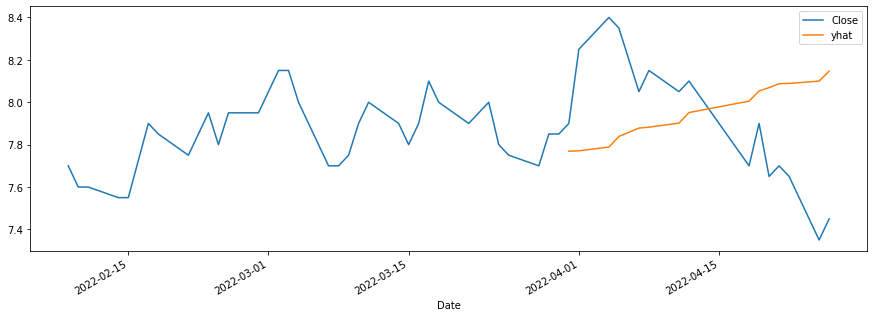

In [ ]:
df_result_Prophet[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

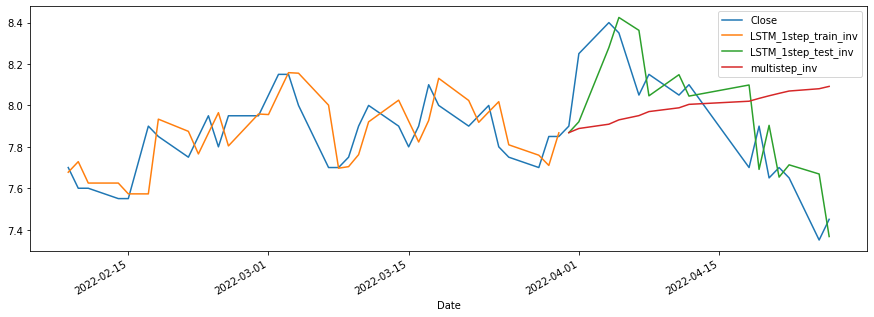

In [ ]:
df_result_LSTM[['Close', 'LSTM_1step_train_inv', 'LSTM_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

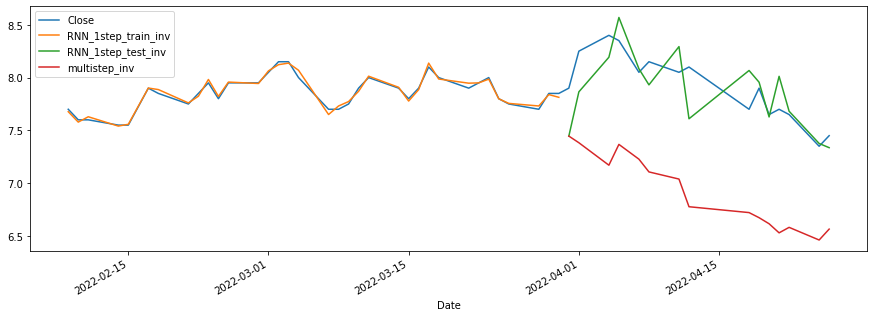

In [ ]:
df_result_RNN[['Close', 'RNN_1step_train_inv', 'RNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

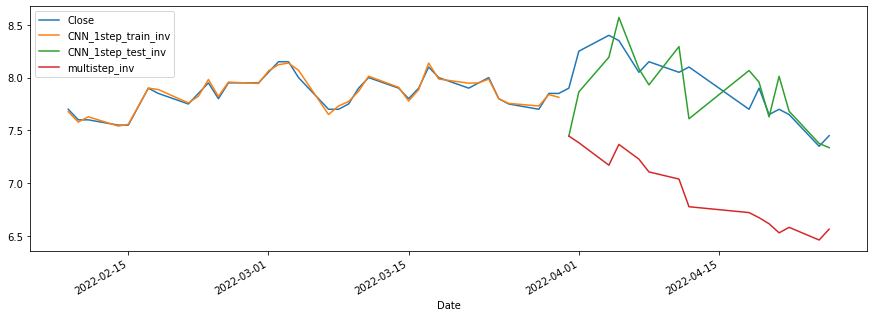

In [ ]:
df_result_CNN[['Close', 'CNN_1step_train_inv', 'CNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

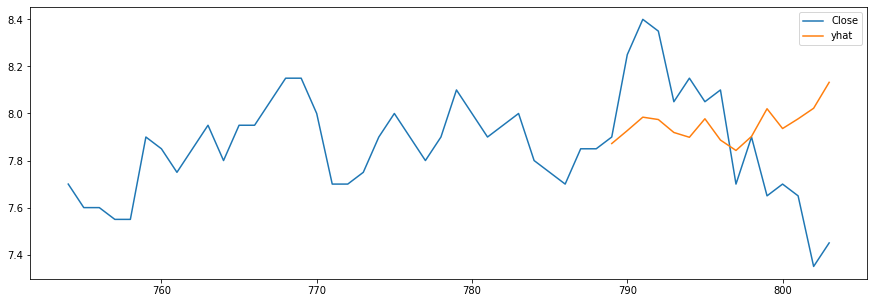

In [ ]:
arima_result[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

### Evaluate model

In [ ]:
# Prophet score 
scores_model_Prophet = cal_score(df_result_Prophet, test_size, selected_stock,scores_model,name_model = "Prophet")

# Auto Arima 
scores_model_Arima = cal_score(arima_result, test_size, selected_stock,scores_model,name_model = "Arima")

#LSTM 
scores_model_LSTM = cal_score_dl(df_result_LSTM, test_size ,scores_model, selected_stock, name_model = "LSTM")

#RNN
scores_model_RNN = cal_score_dl(df_result_RNN, test_size, scores_model, selected_stock, name_model = "RNN")

#CNN
scores_model_CNN = cal_score_dl(df_result_CNN, test_size, scores_model, selected_stock, name_model = "CNN")

# หุ้นที่ 4 = KTB

### Main Function 

In [ ]:
selected_stock = "KTB.BK" 
def predict_stock_lstm(selected_stock, START, TODAY, time_step):
  data =  load_data(selected_stock,START, TODAY)
  train, test ,df_log = train_test_log(data,test_size)
  df_log,sc =  standard_scale(train, test, df_log)
  X_log, y_log = create_dataset(df_log, time_step)
  X_train_log, y_train_log,X_test_log, y_test_log = split_train_test_xy_log(X_log,y_log,test_size)

  #Prophet
  train_set,test_set = create_data_prophet(data, test_size)
  df_result_Prophet = prophet_model(train_set, test_set, data)

  #LSTM 
  history,model_LSTM = LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_LSTM = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_LSTM, sc, name_model = "LSTM")

  #RNN
  history,model_RNN = RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_RNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_RNN, sc, name_model = "RNN") 

  #Conv1D
  history,model_CNN = CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_CNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_CNN, sc, name_model = "CNN") 

  #Auto Arima 
  arima_result = auto_arima_model(train_set, test_set, data)
  
  return df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result

In [ ]:
df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result = predict_stock_lstm(selected_stock, START, TODAY, time_step)

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


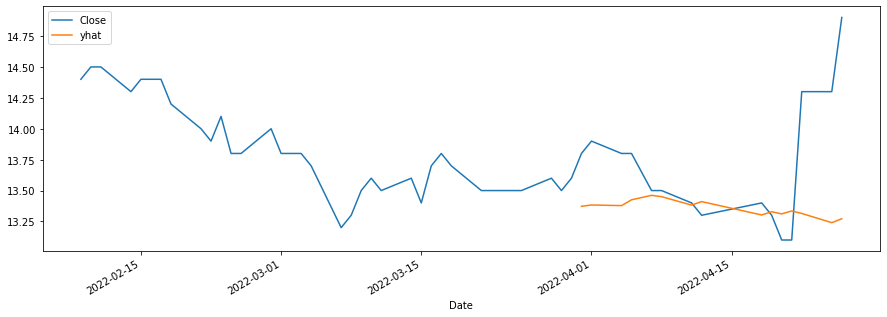

In [ ]:
df_result_Prophet[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

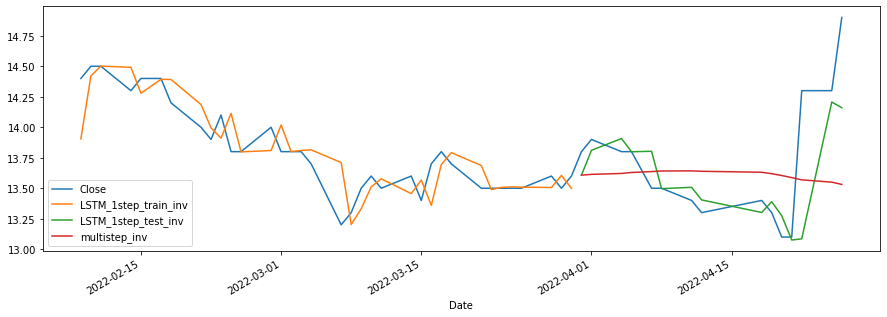

In [ ]:
df_result_LSTM[['Close', 'LSTM_1step_train_inv', 'LSTM_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

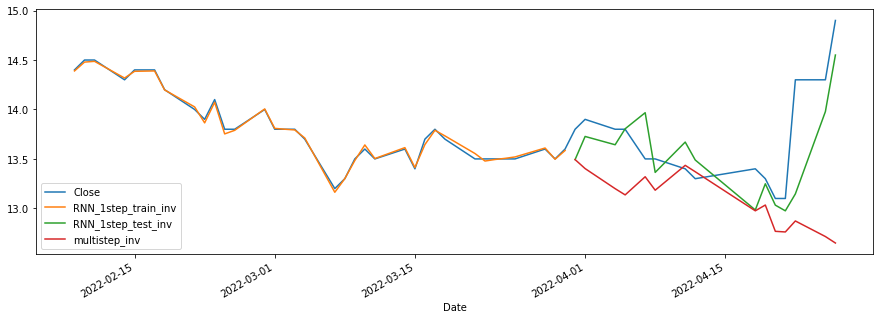

In [ ]:
df_result_RNN[['Close', 'RNN_1step_train_inv', 'RNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

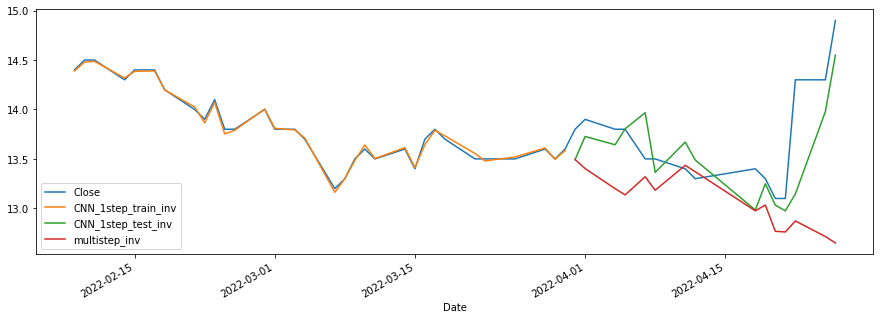

In [ ]:
df_result_CNN[['Close', 'CNN_1step_train_inv', 'CNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

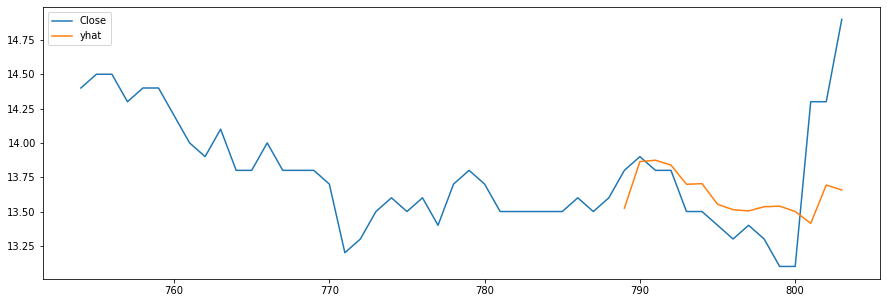

In [ ]:
arima_result[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

### Evaluate model

In [ ]:
# Prophet score 
scores_model_Prophet = cal_score(df_result_Prophet, test_size, selected_stock,scores_model,name_model = "Prophet")

# Auto Arima 
scores_model_Arima = cal_score(arima_result, test_size, selected_stock,scores_model,name_model = "Arima")

#LSTM 
scores_model_LSTM = cal_score_dl(df_result_LSTM, test_size ,scores_model, selected_stock, name_model = "LSTM")

#RNN
scores_model_RNN = cal_score_dl(df_result_RNN, test_size, scores_model, selected_stock, name_model = "RNN")

#CNN
scores_model_CNN = cal_score_dl(df_result_CNN, test_size, scores_model, selected_stock, name_model = "CNN")

# หุ้น 5 = MEGA.BK

### Main Function 

In [ ]:
selected_stock = "MEGA.BK" 
def predict_stock_lstm(selected_stock, START, TODAY, time_step):
  data =  load_data(selected_stock,START, TODAY)
  train, test ,df_log = train_test_log(data,test_size)
  df_log,sc =  standard_scale(train, test, df_log)
  X_log, y_log = create_dataset(df_log, time_step)
  X_train_log, y_train_log,X_test_log, y_test_log = split_train_test_xy_log(X_log,y_log,test_size)

  #Prophet
  train_set,test_set = create_data_prophet(data, test_size)
  df_result_Prophet = prophet_model(train_set, test_set, data)

  #LSTM 
  history,model_LSTM = LSTM_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_LSTM = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_LSTM, sc, name_model = "LSTM")

  #RNN
  history,model_RNN = RNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_RNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_RNN, sc, name_model = "RNN") 

  #Conv1D
  history,model_CNN = CNN_model(X_train_log,y_train_log,X_test_log,y_test_log, time_step)
  df_result_CNN = predict_result(X_train_log, X_test_log, df_log, time_step, test_size, train, model_CNN, sc, name_model = "CNN") 

  #Auto Arima 
  arima_result = auto_arima_model(train_set, test_set, data)
  
  return df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result

In [ ]:
df_result_Prophet, df_result_LSTM, df_result_RNN, df_result_CNN, arima_result = predict_stock_lstm(selected_stock, START, TODAY, time_step)

[*********************100%***********************]  1 of 1 completed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


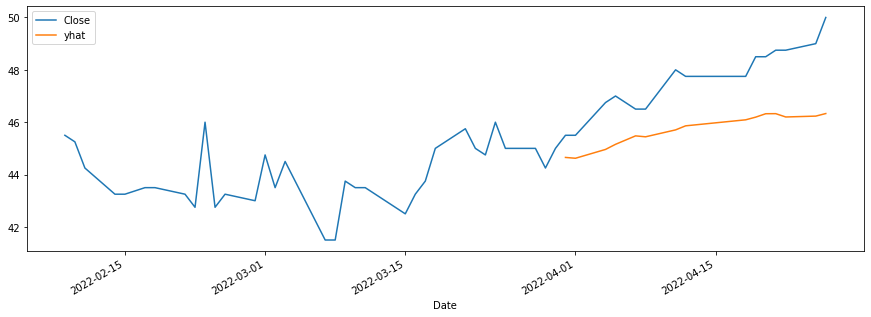

In [ ]:
df_result_Prophet[['Close', 'yhat']].iloc[-50:].plot(figsize=(15, 5))

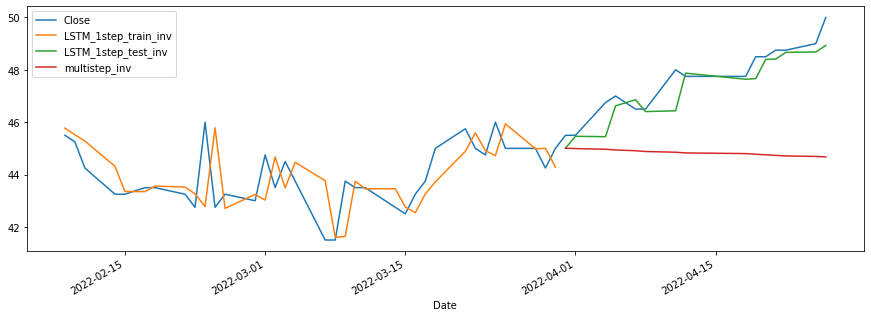

In [ ]:
df_result_LSTM[['Close', 'LSTM_1step_train_inv', 'LSTM_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

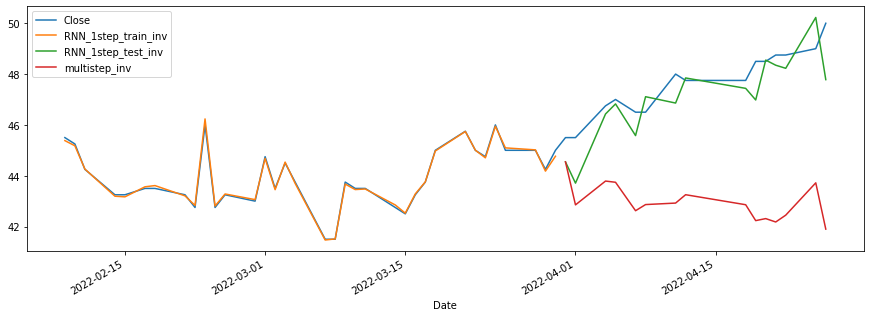

In [ ]:
df_result_RNN[['Close', 'RNN_1step_train_inv', 'RNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

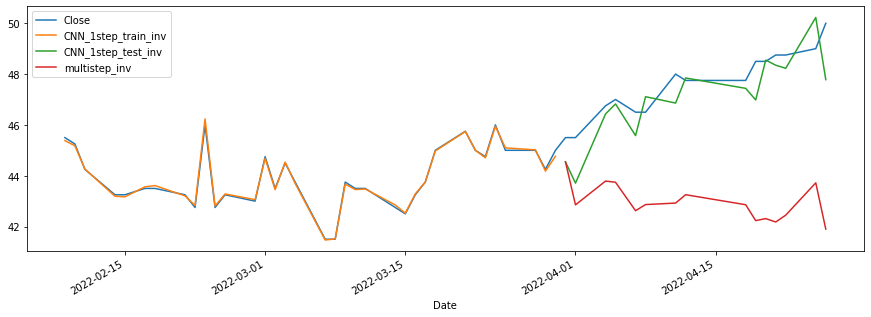

In [ ]:
df_result_CNN[['Close', 'CNN_1step_train_inv', 'CNN_1step_test_inv', 'multistep_inv']].iloc[-50:].plot(figsize=(15, 5))

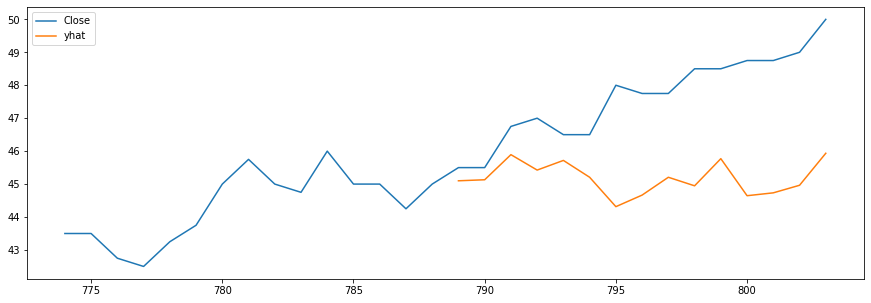

In [ ]:
arima_result[['Close', 'yhat']].iloc[-30:].plot(figsize=(15, 5))

### Evaluate model

In [ ]:
# Prophet score 
scores_model_Prophet = cal_score(df_result_Prophet, test_size, selected_stock,scores_model,name_model = "Prophet")

# Auto Arima 
scores_model_Arima = cal_score(arima_result, test_size, selected_stock,scores_model,name_model = "Arima")

#LSTM 
scores_model_LSTM = cal_score_dl(df_result_LSTM, test_size ,scores_model, selected_stock, name_model = "LSTM")

#RNN
scores_model_RNN = cal_score_dl(df_result_RNN, test_size, scores_model, selected_stock, name_model = "RNN")

#CNN
scores_model_CNN = cal_score_dl(df_result_CNN, test_size, scores_model, selected_stock, name_model = "CNN")

# Result

หลังจากที่ได้ทำการทดสอบผ่านโมเดลทัั้งหมด 5 โมเดล เป้นจำนวน 5 หุ้นแล้วเราจะนำผลลัพธ์ที่ได้มาเทียบกับผลลัพธ์จริง เพื่อหา MAE, MSE และ RMSE

In [ ]:
results = pd.DataFrame(scores_model).sort_values(by='RMSE',ascending=True)
results

,Model,MAE,MSE,RMSE,Stock
2,LSTM,0.171471,0.041938,0.204789,AMATA.BK
0,Prophet,0.255552,0.118633,0.344431,AMATA.BK
11,Arima,0.282820,0.119147,0.345177,PLANB.BK
12,LSTM,0.315981,0.142093,0.376953,PLANB.BK
10,Prophet,0.374663,0.180681,0.425066,PLANB.BK
16,Arima,0.340493,0.223457,0.472712,KTB.BK
17,LSTM,0.405323,0.267348,0.517057,KTB.BK
1,Arima,0.455575,0.293546,0.541799,AMATA.BK
15,Prophet,0.413450,0.375872,0.613084,KTB.BK
19,CNN,0.619687,0.758100,0.870689,KTB.BK


In [ ]:
result_g = results.groupby(by = "Model").mean()
result_g.sort_values(by='RMSE',ascending=True)

,MAE,MSE,RMSE
Model,,,
LSTM,1.359740,4.422179,1.534705
Arima,1.551491,6.048922,1.768411
CNN,1.707571,6.214834,1.937685
RNN,1.707571,6.214834,1.937685
Prophet,3.093885,32.774764,3.214774


ผลลัพธ์เมื่อจัดเรียงตาม RMSE เฉลี่ยที่ได้จาก 5 หุ้น จากน้อยไปมาก จะเห็นได้ว่า โมเดล LSTM ได้ผลลัพธ์ที่ดีกว่าโมเดลอื่นๆ เพราะฉะนั้นในขั้นตอนถัดไป เราจะเลือกโมเดล LSTM ไปใช้ในการทำแอพพลิเคชั่นทำนายราคาหุ้น